# 4. AQC Unitary - Trotterisation warm starting

In [1]:
import jax

jax.config.update("jax_enable_x64", True)

1. Trotterisation

In [2]:
t = 0.25
n_repetitions = 6
degree = 2

In [3]:
# Ising-1d
from ropt_aqc.initialise_hamiltonians import get_hamiltonian_terms, hamiltonian_to_sparse_pauli_op, build_matrix_from_terms
from qiskit import QuantumCircuit
from scipy.linalg import expm
from qiskit.quantum_info import Statevector

method = 'Trott'
num_sites = 6
n_id_layers = 0

J=1.
g=0.75
h=0.6
system = 'ising-1d'

terms, params = get_hamiltonian_terms(num_qubits=num_sites, system=system, J=J, g=g, h=h)
J = params['J']
h = params['h']
g = params['g']

H_sparse = hamiltonian_to_sparse_pauli_op(terms, num_qubits=num_sites)
print(H_sparse)


# Generate an initial state
initial_state = QuantumCircuit(num_sites)
for i in range(num_sites):
    if i % 2:
        initial_state.x(i)


H = build_matrix_from_terms(terms, num_sites)

# Exact evolution operator
U_exact = expm(-1j * t * H)

# Initial statevector
initial_sv = Statevector(initial_state)

# Apply exact evolution
reference_state = initial_sv.evolve(U_exact)

SparsePauliOp(['ZZIIII', 'IZZIII', 'IIZZII', 'IIIZZI', 'IIIIZZ', 'ZIIIII', 'XIIIII', 'IZIIII', 'IXIIII', 'IIZIII', 'IIXIII', 'IIIZII', 'IIIXII', 'IIIIZI', 'IIIIXI', 'IIIIIZ', 'IIIIIX'],
              coeffs=[1.  +0.j, 1.  +0.j, 1.  +0.j, 1.  +0.j, 1.  +0.j, 0.6 +0.j, 0.75+0.j,
 0.6 +0.j, 0.75+0.j, 0.6 +0.j, 0.75+0.j, 0.6 +0.j, 0.75+0.j, 0.6 +0.j,
 0.75+0.j, 0.6 +0.j, 0.75+0.j])


In [4]:
from ropt_aqc.trotterisation import trotterisation

final_circuit, fidelity = trotterisation(degree, H_sparse, t, n_repetitions, initial_state, num_sites, terms)
print('t:', t, 'n_reps:', n_repetitions)
print('Fidelity: ', fidelity)
print('depth:', final_circuit.depth())

from qiskit.qasm2 import dumps

with open("trotter_circuit.qasm", "w") as f:
    f.write(dumps(final_circuit))


t: 0.25 n_reps: 6
Fidelity:  0.9996896219711732
depth: 121


2. AQC unitary 

Change environment

In [1]:

from qiskit import QuantumCircuit
# Load from QASM
with open("trotter_circuit.qasm", "r") as f:
    qc_str = f.read()
    final_circuit = QuantumCircuit.from_qasm_str(qc_str)

print(final_circuit.depth())

121


In [2]:
from qiskit import transpile

# Decompose to U3 + CX (universal gate set with 1- and 2-qubit gates)
basis_gates = ['rx', 'ry', 'rz', 'cx'] 

decomposed_circuit = transpile(
    final_circuit,
    basis_gates=basis_gates,
    optimization_level=0  # No optimization, just decomposition
)


In [3]:
from ropt_aqc.initialise_hamiltonians import get_hamiltonian_terms, build_matrix_from_terms

method = 'AQC-unitary'
num_sites = 6
degree = 2
n_repetitions = 5
n_id_layers = 0
evolution_time = 2.0

In [4]:
# Ising-1d
J=1.
g=0.75
h=0.6
system = 'ising-1d'

terms, params = get_hamiltonian_terms(num_qubits=num_sites, system=system, J=J, g=g, h=h)

J = params['J']
h = params['h']
g = params['g']

In [5]:
from ropt_aqc.initialise_hamiltonians import hamiltonian_to_sparse_pauli_op
from qiskit.quantum_info import SparsePauliOp
from rustworkx.generators import path_graph

hamiltonian = hamiltonian_to_sparse_pauli_op(terms, num_qubits=num_sites)
print('Hamiltonian: ', hamiltonian)

observable = SparsePauliOp.from_sparse_list(
    [("ZZ", (num_sites // 2 - 1, num_sites // 2), 1.0)], num_qubits=num_sites
)
print("Observable:", observable)

coupling_map = path_graph(num_sites)

Hamiltonian:  SparsePauliOp(['ZZIIII', 'IZZIII', 'IIZZII', 'IIIZZI', 'IIIIZZ', 'ZIIIII', 'XIIIII', 'IZIIII', 'IXIIII', 'IIZIII', 'IIXIII', 'IIIZII', 'IIIXII', 'IIIIZI', 'IIIIXI', 'IIIIIZ', 'IIIIIX'],
              coeffs=[1.        +0.j, 1.        +0.j, 1.        +0.j, 1.        +0.j,
 1.        +0.j, 0.60000002+0.j, 0.75      +0.j, 0.60000002+0.j,
 0.75      +0.j, 0.60000002+0.j, 0.75      +0.j, 0.60000002+0.j,
 0.75      +0.j, 0.60000002+0.j, 0.75      +0.j, 0.60000002+0.j,
 0.75      +0.j])
Observable: SparsePauliOp(['IIZZII'],
              coeffs=[1.+0.j])


This single Trotter step circuit will be repeated 256 times:


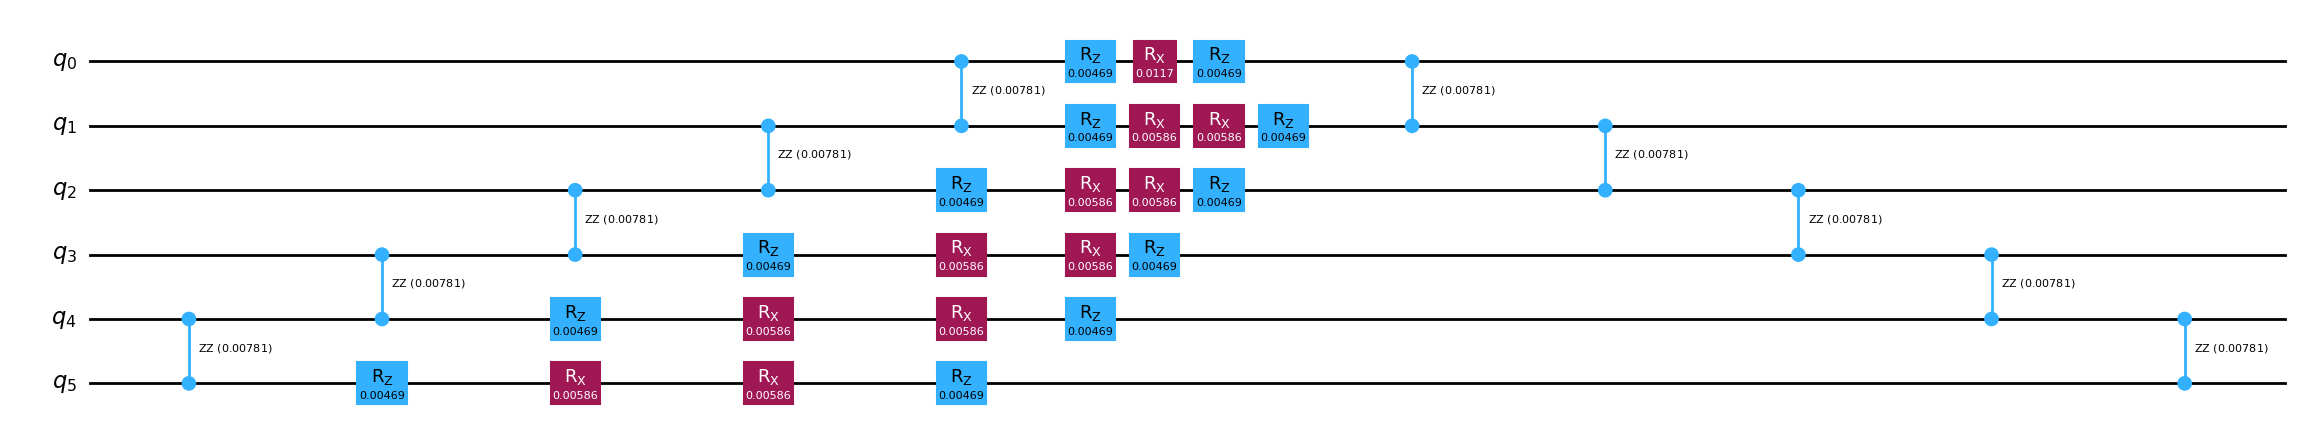

In [6]:
# Construct a single Trotter step of the target circuit
from qiskit.synthesis import SuzukiTrotter
from qiskit_addon_utils.problem_generators import generate_time_evolution_circuit

aqc_evolution_time = evolution_time
aqc_target_log2_num_trotter_steps = 8

aqc_target_step_circuit = generate_time_evolution_circuit(
    hamiltonian,
    synthesis=SuzukiTrotter(reps=1),
    time=aqc_evolution_time / 2**aqc_target_log2_num_trotter_steps,
)

print(
    f"This single Trotter step circuit will be repeated {2**aqc_target_log2_num_trotter_steps} times:"
)
aqc_target_step_circuit.draw("mpl", fold=-1)

In [7]:
# construct a good cirucit

ansatz_num_trotter_steps = 2

aqc_good_circuit = generate_time_evolution_circuit(
    hamiltonian,
    synthesis=SuzukiTrotter(reps=ansatz_num_trotter_steps),
    time=aqc_evolution_time,
)


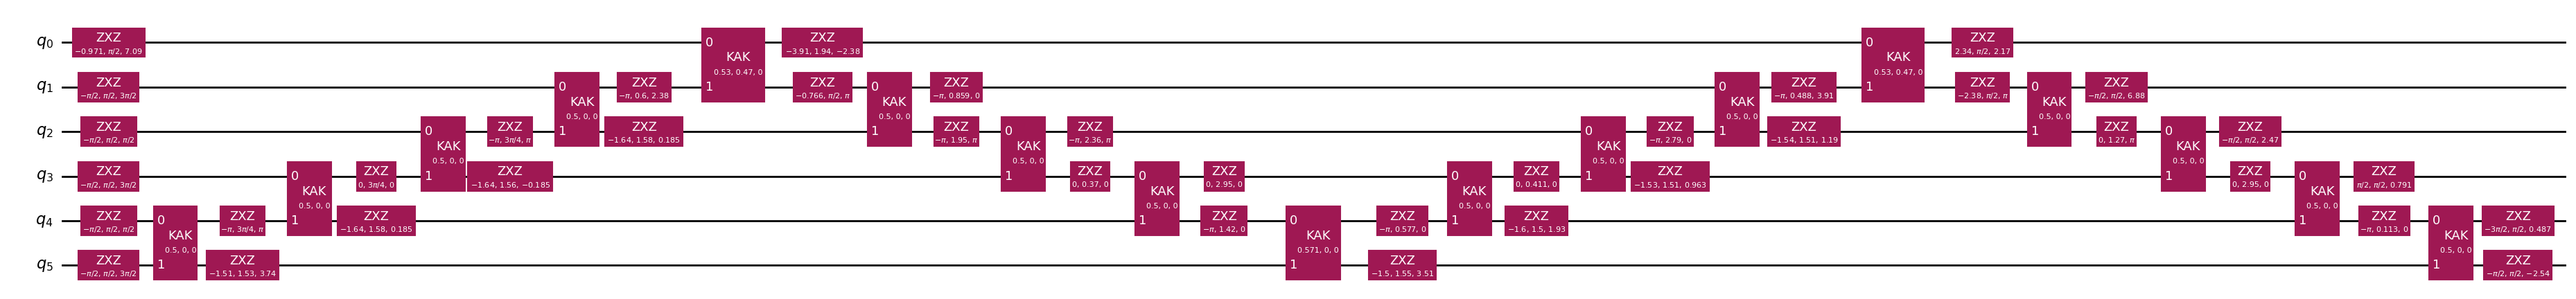

In [8]:
# generate ansatz from a good circuit

from qiskit_addon_aqc_tensor import generate_ansatz_from_circuit

aqc_ansatz, aqc_initial_parameters = generate_ansatz_from_circuit(
    aqc_good_circuit, parameter_name="x"
)
aqc_ansatz.assign_parameters(aqc_initial_parameters).draw("mpl", fold=-1)

In [9]:
depth = aqc_ansatz.depth()
print(depth)

35


In [10]:
# set up quimb
from functools import partial
import quimb.tensor
from qiskit_addon_aqc_tensor.simulation.quimb import QuimbSimulator

simulator_settings = QuimbSimulator(
    partial(quimb.tensor.Circuit, gate_contract="split-gate"),
    autodiff_backend="jax",
)

/Users/aag/Documents/ropt-aqc/ropt-aqc_venv/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:54: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/Users/aag/Documents/ropt-aqc/ropt-aqc_venv/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:73: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(


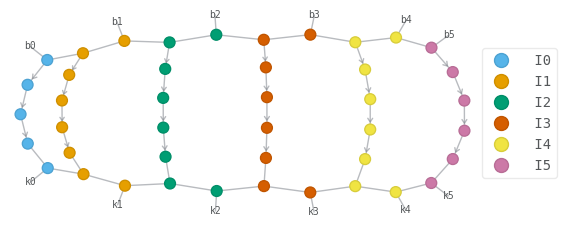

In [11]:
# construct target MPO - tensor network of single trotter step of target circuit
from qiskit_addon_aqc_tensor.simulation import tensornetwork_from_circuit

aqc_target_mpo = tensornetwork_from_circuit(aqc_target_step_circuit, simulator_settings).get_uni()
aqc_target_mpo.draw(aqc_target_mpo.site_tags, show_tags=False)

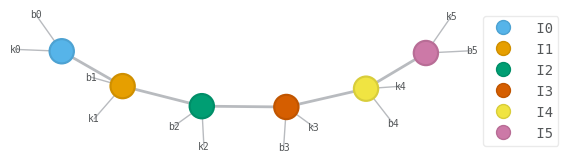

In [12]:
# contract and fuse multibonds to form MPO

for site in aqc_target_mpo.site_tags:
    aqc_target_mpo.contract(site, inplace=True)
aqc_target_mpo.fuse_multibonds_()

aqc_target_mpo.draw(aqc_target_mpo.site_tags, show_tags=False)

In [13]:
# cast to MPO object and compress

cutoff = 1e-8

aqc_target_mpo.view_as_(
    quimb.tensor.MatrixProductOperator,
    cyclic=False,
    L=coupling_map.num_nodes(),
)
aqc_target_mpo.compress(cutoff=cutoff)
aqc_target_mpo.show()

│2│2│2│2│2│
●─<─<─<─<─<
│ │ │ │ │ │


In [14]:
# repeatedly sqaure and compress MPO to represent an operator with many Trotter steps
for _ in range(aqc_target_log2_num_trotter_steps):
    aqc_target_mpo = aqc_target_mpo.apply(aqc_target_mpo)
    aqc_target_mpo.compress(cutoff=cutoff)
    aqc_target_mpo.show()
aqc_target_mpo

│2│2│2│2│2│
●─<─<─<─<─<
│ │ │ │ │ │
│2│2│2│2│2│
●─<─<─<─<─<
│ │ │ │ │ │
│2│2│2│2│2│
●─<─<─<─<─<
│ │ │ │ │ │
│3│3│3│3│3│
●─<─<─<─<─<
│ │ │ │ │ │
│4│4│4│4│4│
●─<─<─<─<─<
│ │ │ │ │ │
│4│6│6│6│4│
●─<─<─<─<─<
│ │ │ │ │ │
│4│10│10│10│4│
●─<──<──<──<─<
│ │  │  │  │ │
│4│16│24│16│4│
●─<──<──<──<─<
│ │  │  │  │ │


MatrixProductOperator(tensors=6, indices=17, L=6, max_bond=24)

In [15]:
from scipy.optimize import OptimizeResult, minimize

from qiskit_addon_aqc_tensor.objective import MaximizeUnitaryFidelity

aqc_ansatz, aqc_initial_parameters = generate_ansatz_from_circuit(decomposed_circuit)

objective = MaximizeUnitaryFidelity(aqc_target_mpo, aqc_ansatz, simulator_settings)

stopping_point = 1e-4


def my_loss_function(*args):
    val, grad = objective.loss_function(*args)
    print(f"Evaluating loss function: {1 - val:.8}")
    return val, grad


def callback(intermediate_result: OptimizeResult):
    print(f"Intermediate result: Fidelity {1 - intermediate_result.fun:.8}")
    if intermediate_result.fun < stopping_point:
        # Good enough for now
        raise StopIteration


result = minimize(
    my_loss_function,
    aqc_initial_parameters,
    method="L-BFGS-B",
    jac=True,
    options={"maxiter": 100},
    callback=callback,
)
if result.status not in (
    0,
    1,
    99,
):  # 0 => success; 1 => max iterations reached; 99 => early termination via StopIteration
    raise RuntimeError(f"Optimization failed: {result.message} (status={result.status})")

print(f"Done after {result.nit} iterations.")
aqc_final_parameters = result.x

Evaluating loss function: 0.043972731
Evaluating loss function: 0.043354571
Evaluating loss function: 0.091623127
Intermediate result: Fidelity 0.091623127
Evaluating loss function: 0.11717689
Intermediate result: Fidelity 0.11717689
Evaluating loss function: 0.15128076
Intermediate result: Fidelity 0.15128076
Evaluating loss function: 0.21435595
Intermediate result: Fidelity 0.21435595
Evaluating loss function: 0.087324977
Evaluating loss function: 0.26125979
Intermediate result: Fidelity 0.26125979
Evaluating loss function: 0.30718398
Intermediate result: Fidelity 0.30718398
Evaluating loss function: 0.37001097
Intermediate result: Fidelity 0.37001097
Evaluating loss function: 0.42902172
Intermediate result: Fidelity 0.42902172
Evaluating loss function: 0.52318078
Intermediate result: Fidelity 0.52318078
Evaluating loss function: 0.55243462
Intermediate result: Fidelity 0.55243462
Evaluating loss function: 0.58975196
Intermediate result: Fidelity 0.58975196
Evaluating loss function: 

=== Complete Optimised Circuit ===


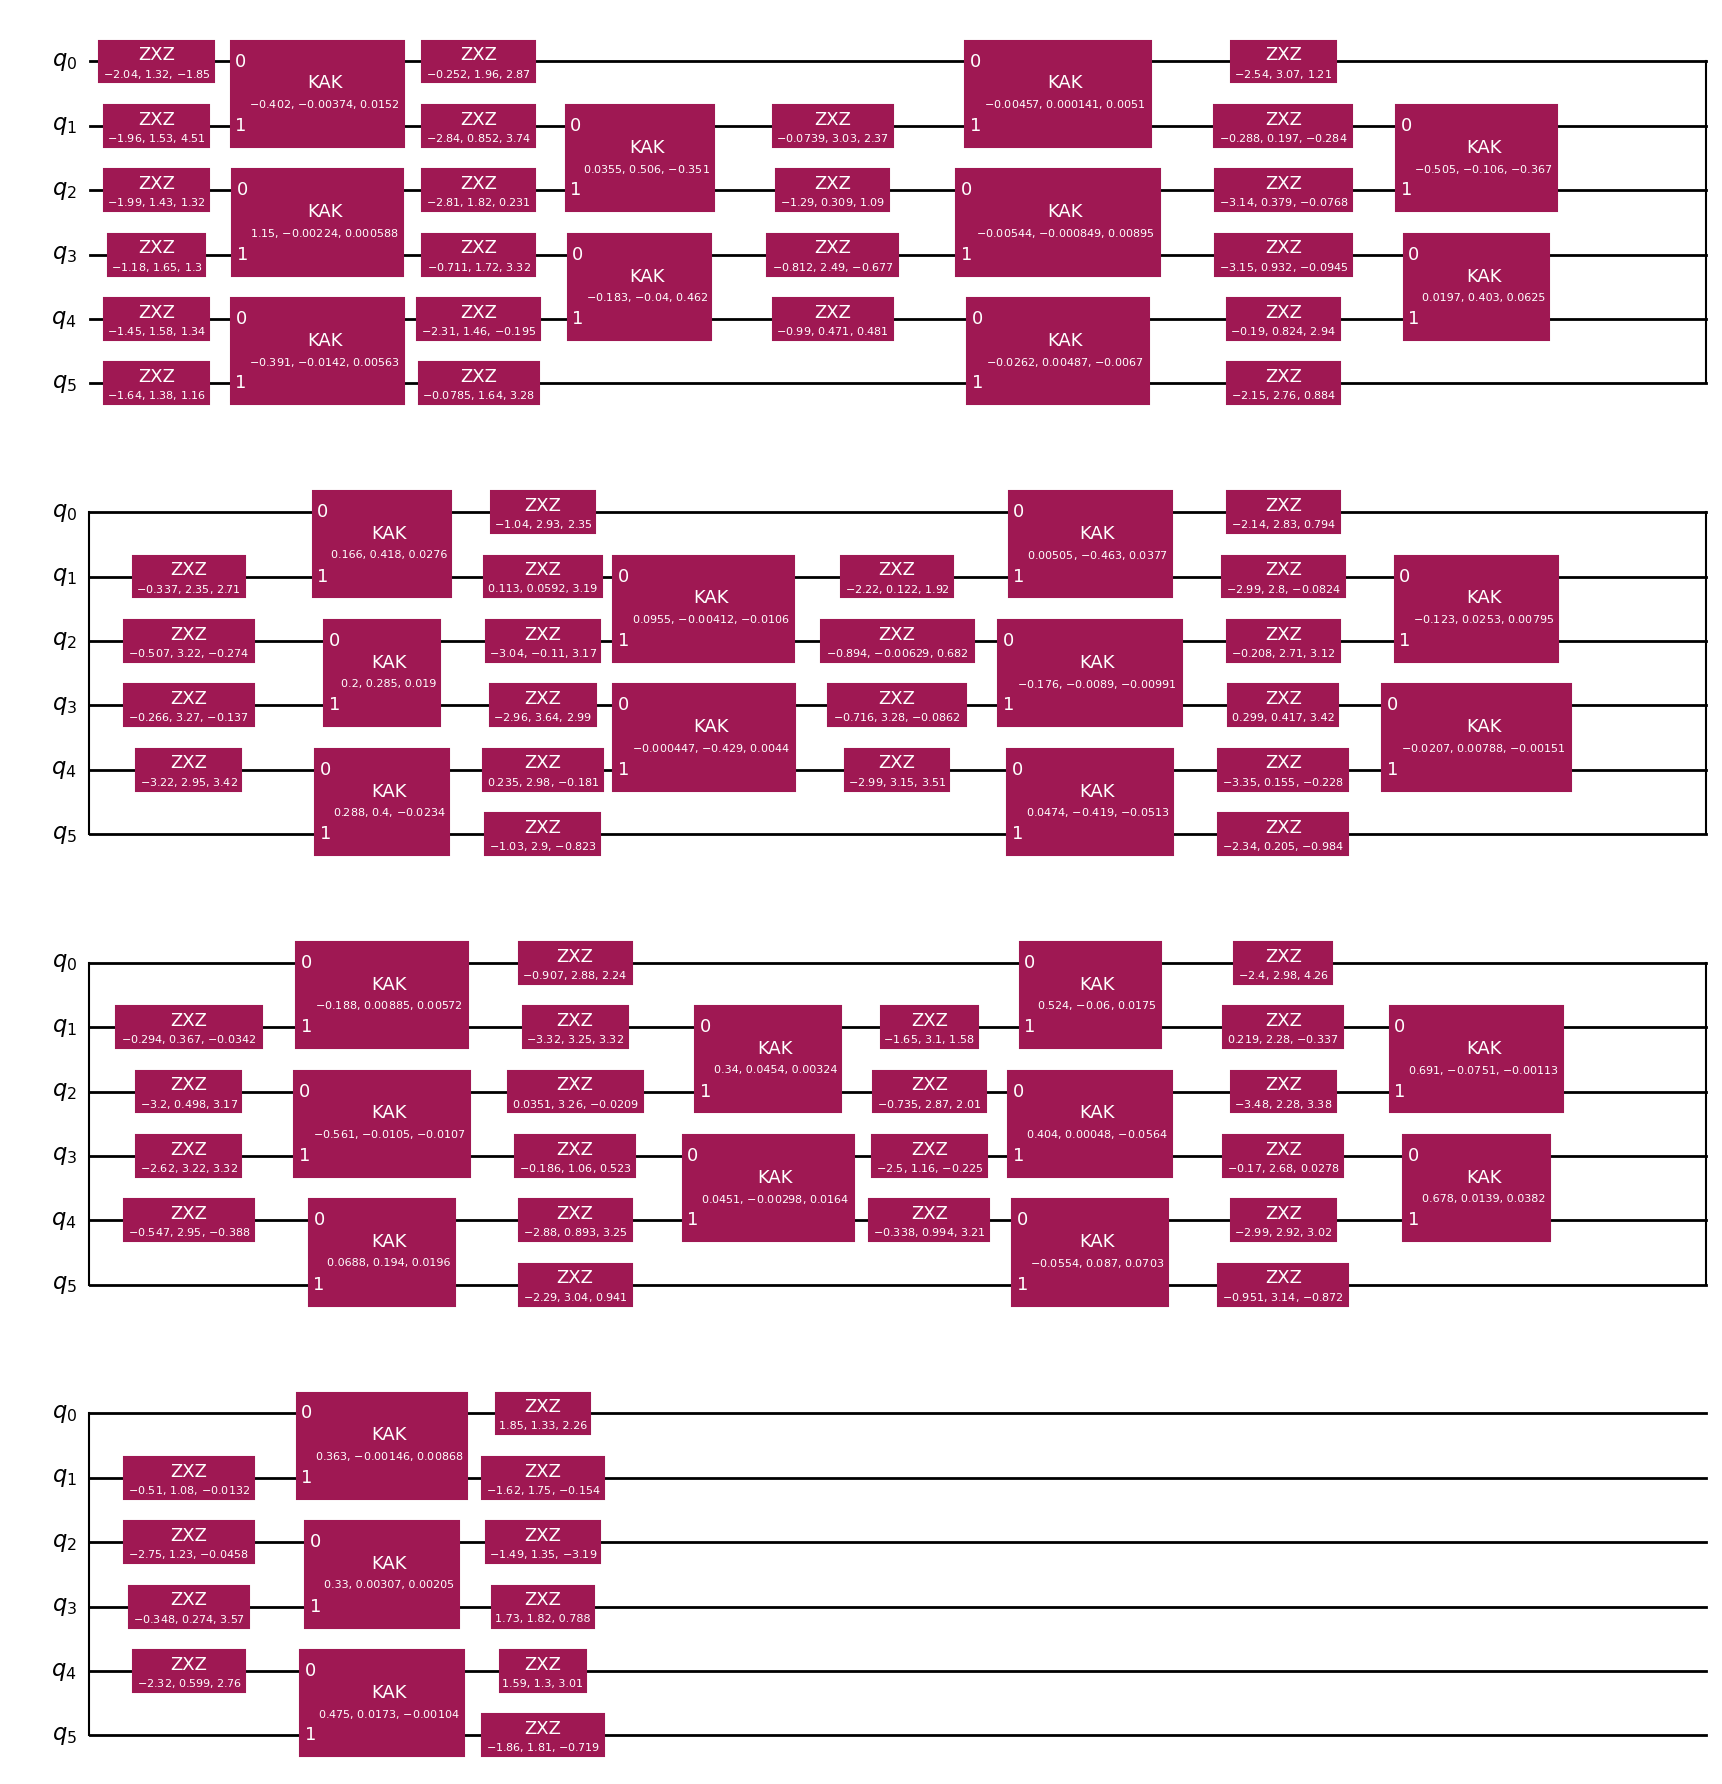

In [16]:
# from the optimised circuit 
aqc_optimised_block = aqc_ansatz.assign_parameters(aqc_final_parameters)
print("=== Complete Optimised Circuit ===")
aqc_optimised_block.draw("mpl")

In [17]:
depth = aqc_optimised_block.depth()
print(depth)

27


In [18]:
# calculate Frobenius inner product 
import numpy as np
from qiskit.quantum_info import Operator

if coupling_map.num_nodes() <= 8:
    target_operator = Operator(aqc_target_step_circuit).power(2**aqc_target_log2_num_trotter_steps)
    
    initial_fidelity = abs(
        np.trace(Operator(aqc_good_circuit).conjugate().to_matrix() @ target_operator.to_matrix())
        / 2.0 ** coupling_map.num_nodes()
    )
    print(f"Initial Frobenius inner product: {initial_fidelity:.8}")

    final_fidelity = abs(
        np.trace(
            Operator(aqc_optimised_block).conjugate().to_matrix() @ target_operator.to_matrix()
        )
        / 2.0 ** coupling_map.num_nodes()
    )
    print(f"Final Frobenius inner product: {final_fidelity:.8}")

Initial Frobenius inner product: 0.32865239
Final Frobenius inner product: 0.99923572


The final circuit implements evolution of the Hamiltonian for time = 8.0.


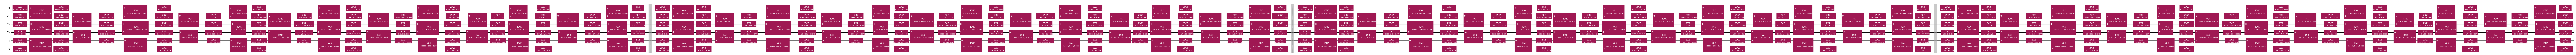

In [19]:
# Form final circuit by repeating the block
num_repeats = 4

print(
    f"The final circuit implements evolution of the Hamiltonian for time = {num_repeats * aqc_evolution_time}."
)  # FIXME: can i say anything about the fidelity??  ignoring cutoff/roundoff error of course
final_circuit = aqc_optimised_block.repeat(num_repeats)

aqc_optimised_block.repeat(num_repeats, insert_barriers=True).decompose().draw("mpl", fold=-1)

In [20]:
# Now slice and compress
from ropt_aqc.comparison_methods import compress_AQC_unitary

N_vals = range(1, depth)
df, aqc_ansatz, aqc_initial_parameters, aqc_final_parameters = compress_AQC_unitary(aqc_ansatz, aqc_initial_parameters, aqc_good_circuit, aqc_target_mpo, N_vals, simulator_settings, n_repetitions)


=== Optimizing with N = 1 layers ===
Evaluating loss function: 0.0034204003
Evaluating loss function: 0.018610082
Intermediate result: Fidelity 0.018610082
Evaluating loss function: 0.0079285282
Evaluating loss function: 0.034570222
Intermediate result: Fidelity 0.034570222
Evaluating loss function: 0.044626318
Intermediate result: Fidelity 0.044626318
Evaluating loss function: 0.063900478
Intermediate result: Fidelity 0.063900478
Evaluating loss function: 0.071484727
Intermediate result: Fidelity 0.071484727
Evaluating loss function: 0.077445587
Intermediate result: Fidelity 0.077445587
Evaluating loss function: 0.077261498
Evaluating loss function: 0.078160992
Intermediate result: Fidelity 0.078160992
Evaluating loss function: 0.078478172
Intermediate result: Fidelity 0.078478172
Evaluating loss function: 0.07855622
Intermediate result: Fidelity 0.07855622
Evaluating loss function: 0.078821614
Intermediate result: Fidelity 0.078821614
Evaluating loss function: 0.079049923
Intermedia

In [22]:
import pandas as pd
file_path_ising = f'/Users/aag/Documents/ropt-aqc/method_comparison/results/AQC_unitary_trotterisation_Ising_results_0.25_.csv'

df.to_csv(file_path_ising, index=False, header=True)
# df.to_csv(file_path_ising, index=False, mode="a", header=False)


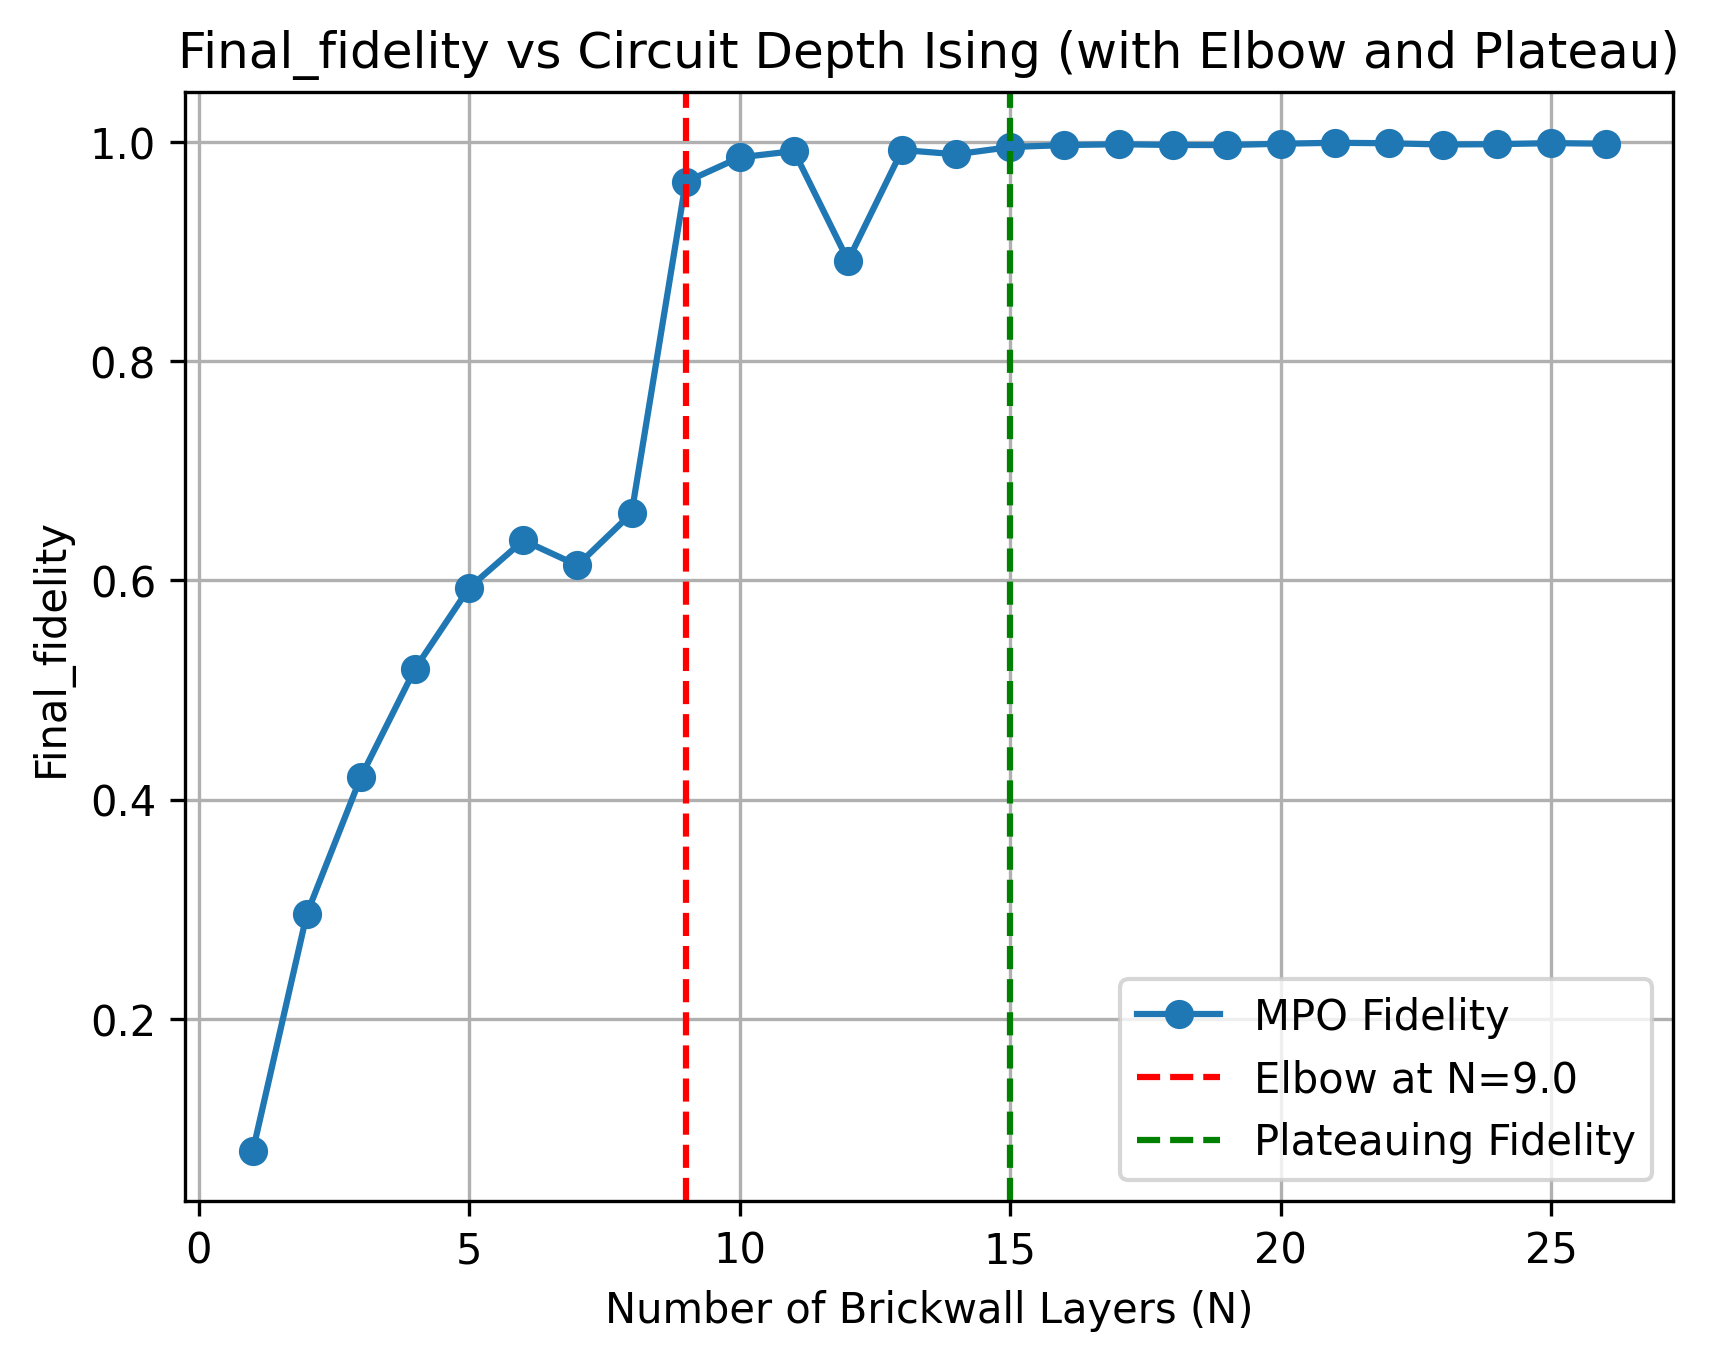


🔍 Suggested optimal compression depth: N = 15.0


In [23]:
from ropt_aqc.brickwall_opt import plot_fidelity
df = pd.read_csv(file_path_ising)

elbow_N, plateau_N = plot_fidelity(df, 'Final_fidelity', evolution_time, 1e-2, method, system, save_path=True)

In [21]:
# Compress circuit
from ropt_aqc.comparison_methods import compress_AQC_unitary

# N_vals = [int(plateau_N)]
N_vals = [33]
df_compressed, aqc_ansatz_compressed, aqc_initial_parameters_compressed, aqc_final_parameters_compressed = compress_AQC_unitary(aqc_ansatz, aqc_initial_parameters, aqc_good_circuit, aqc_target_mpo, N_vals, simulator_settings, n_repetitions)


=== Optimizing with N = 33 layers ===
Evaluating loss function: 0.089641546
Evaluating loss function: 0.3099762
Intermediate result: Fidelity 0.3099762
Evaluating loss function: 0.24171717
Evaluating loss function: 0.37282872
Intermediate result: Fidelity 0.37282872
Evaluating loss function: 0.51132394
Intermediate result: Fidelity 0.51132394
Evaluating loss function: 0.41671701
Evaluating loss function: 0.63785597
Intermediate result: Fidelity 0.63785597
Evaluating loss function: 0.73317089
Intermediate result: Fidelity 0.73317089
Evaluating loss function: 0.80564603
Intermediate result: Fidelity 0.80564603
Evaluating loss function: 0.85146576
Intermediate result: Fidelity 0.85146576
Evaluating loss function: 0.88329117
Intermediate result: Fidelity 0.88329117
Evaluating loss function: 0.90574131
Intermediate result: Fidelity 0.90574131
Evaluating loss function: 0.92139455
Intermediate result: Fidelity 0.92139455
Evaluating loss function: 0.93495212
Intermediate result: Fidelity 0.93

In [22]:
print("=== Compressed Optimised Circuit ===")

param_binding = {param: value for param, value in zip(aqc_ansatz_compressed.parameters, aqc_final_parameters_compressed)}
aqc_optimised_compressed = aqc_ansatz_compressed.assign_parameters(param_binding)

aqc_optimised_compressed.draw("mpl")
aqc_optimised_compressed.draw("mpl").savefig('optimised_circuit_AQC-u_Ising.pdf')

=== Compressed Optimised Circuit ===


In [24]:
print("\n=== Compressed Optimised Parameters ===")
import pandas as pd
for param, value in zip(aqc_ansatz_compressed.parameters, aqc_final_parameters_compressed):
    print(f"{param}: {value:.6f}")

df_params = pd.DataFrame({'parameters': aqc_final_parameters_compressed})
df_params.to_csv('aqc_unitary_parameters_Ising.csv', index=False)


=== Compressed Optimised Parameters ===
x[0]: -0.993831
x[1]: 1.704573
x[2]: 6.901356
x[3]: -1.591118
x[4]: 1.564426
x[5]: 4.476437
x[6]: -1.559196
x[7]: 1.560501
x[8]: 1.287993
x[9]: -1.797327
x[10]: 1.407949
x[11]: 4.341333
x[12]: -2.369698
x[13]: 1.208798
x[14]: 1.320851
x[15]: -1.760783
x[16]: 1.204503
x[17]: 4.230942
x[18]: 0.604689
x[19]: 0.011579
x[20]: -0.043093
x[21]: -3.110047
x[22]: 1.930415
x[23]: 3.333391
x[24]: -0.759691
x[25]: 1.442009
x[26]: 3.415362
x[27]: 0.569287
x[28]: -0.010928
x[29]: 0.009078
x[30]: 0.006790
x[31]: 2.517496
x[32]: 0.137384
x[33]: -2.503677
x[34]: 2.156799
x[35]: 2.735852
x[36]: 0.463527
x[37]: -0.010863
x[38]: -0.000870
x[39]: -3.187663
x[40]: 2.359032
x[41]: 3.235836
x[42]: -2.880347
x[43]: 0.476879
x[44]: 0.648416
x[45]: 0.425240
x[46]: -0.000799
x[47]: 0.001250
x[48]: -3.164749
x[49]: 0.542738
x[50]: 2.503126
x[51]: -2.437825
x[52]: 1.670818
x[53]: 0.163219
x[54]: 0.822849
x[55]: 0.183498
x[56]: -0.004233
x[57]: -1.020835
x[58]: 1.213286
x[59]

In [25]:
print(f"Number of parameters in ansatz: {len(aqc_ansatz_compressed.parameters)}")
print(f"Physical depth of compressed circuit: {aqc_optimised_compressed.depth()}")
print(f"Compression ratio: {depth / aqc_optimised_compressed.depth()}")

Number of parameters in ansatz: 162
Physical depth of compressed circuit: 33
Compression ratio: 1.0606060606060606


# Heisenberg

1. Trotterisation 

In [1]:
evolution_time = 0.2
n_repetitions = 10
degree = 2

In [2]:
from ropt_aqc.initialise_hamiltonians import get_hamiltonian_terms, hamiltonian_to_sparse_pauli_op, build_matrix_from_terms
from qiskit import QuantumCircuit
from scipy.linalg import expm
from qiskit.quantum_info import Statevector

method = 'Trott'
num_sites = 6
n_id_layers = 0

h = 0.75
system = 'heisenberg'

terms_h, params_h = get_hamiltonian_terms(num_qubits=num_sites, system=system, J=[1.0, 1.0, -0.5], h=[0.75, 0.0, 0.0])
J = params_h['J']
h = params_h['h']

H_sparse_h = hamiltonian_to_sparse_pauli_op(terms_h, num_qubits=num_sites)
print(H_sparse_h)


# Generate an initial state
initial_state = QuantumCircuit(num_sites)
for i in range(num_sites):
    if i % 2:
        initial_state.x(i)


H_h = build_matrix_from_terms(terms_h, num_sites)

# Exact evolution operator
U_exact_h = expm(-1j * evolution_time * H_h)

# Initial statevector
initial_sv = Statevector(initial_state)

# Apply exact evolution
reference_state_h = initial_sv.evolve(U_exact_h)

SparsePauliOp(['XXIIII', 'YYIIII', 'ZZIIII', 'IXXIII', 'IYYIII', 'IZZIII', 'IIXXII', 'IIYYII', 'IIZZII', 'IIIXXI', 'IIIYYI', 'IIIZZI', 'IIIIXX', 'IIIIYY', 'IIIIZZ', 'XIIIII', 'IXIIII', 'IIXIII', 'IIIXII', 'IIIIXI', 'IIIIIX'],
              coeffs=[ 1.  +0.j,  1.  +0.j, -0.5 +0.j,  1.  +0.j,  1.  +0.j, -0.5 +0.j,
  1.  +0.j,  1.  +0.j, -0.5 +0.j,  1.  +0.j,  1.  +0.j, -0.5 +0.j,
  1.  +0.j,  1.  +0.j, -0.5 +0.j,  0.75+0.j,  0.75+0.j,  0.75+0.j,
  0.75+0.j,  0.75+0.j,  0.75+0.j])


/Users/aag/Documents/ropt-aqc/ropt_aqc/initialise_hamiltonians.py:143: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  H = jnp.zeros((2**num_qubits, 2**num_qubits), dtype=jnp.complex128)


In [3]:
from ropt_aqc.trotterisation import trotterisation

final_circuit_h, fidelity_h = trotterisation(degree, H_sparse_h, evolution_time, n_repetitions, initial_state, num_sites, terms_h)
print('t:', evolution_time, 'n_reps:', n_repetitions)
print('Fidelity: ', fidelity_h)
print('depth:', final_circuit_h.depth())

from qiskit.qasm2 import dumps

with open("trotter_circuit.qasm", "w") as f:
    f.write(dumps(final_circuit_h))

/Users/aag/Documents/ropt-aqc/ropt_aqc/initialise_hamiltonians.py:143: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  H = jnp.zeros((2**num_qubits, 2**num_qubits), dtype=jnp.complex128)


t: 0.2 n_reps: 10
Fidelity:  0.9999328161047503
depth: 301


2. AQC unitary

change environment

In [1]:
from qiskit import QuantumCircuit
# Load from QASM
with open("trotter_circuit.qasm", "r") as f:
    qc_str = f.read()
    final_circuit_h = QuantumCircuit.from_qasm_str(qc_str)

print(final_circuit_h.depth())

301


In [2]:
from qiskit import transpile

# Decompose to U3 + CX (universal gate set with 1- and 2-qubit gates)
basis_gates = ['rx', 'ry', 'rz', 'cx'] 

decomposed_circuit_h = transpile(
    final_circuit_h,
    basis_gates=basis_gates,
    optimization_level=0  # No optimization, just decomposition
)


In [3]:
# Heisenberg
from ropt_aqc.initialise_hamiltonians import get_hamiltonian_terms
t = 0.2
h = 0.75
system = 'heisenberg'
num_sites = 6
n_repetitions = 5

terms_h, params_h = get_hamiltonian_terms(num_qubits=num_sites, system=system, J=[1.0, 1.0, -0.5], h=[0.75, 0.0, 0.0])

J= params_h['J']
h= params_h['h']

In [4]:
from ropt_aqc.initialise_hamiltonians import hamiltonian_to_sparse_pauli_op
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import CouplingMap
from rustworkx.generators import path_graph


hamiltonian_heisenberg = hamiltonian_to_sparse_pauli_op(terms_h, num_qubits=num_sites)
print('Hamiltonian: ', hamiltonian_heisenberg)

observable = SparsePauliOp.from_sparse_list(
    [("ZZ", (num_sites // 2 - 1, num_sites // 2), 1.0)], num_qubits=num_sites
)
print("Observable:", observable)

coupling_map = path_graph(num_sites)

Hamiltonian:  SparsePauliOp(['XXIIII', 'YYIIII', 'ZZIIII', 'IXXIII', 'IYYIII', 'IZZIII', 'IIXXII', 'IIYYII', 'IIZZII', 'IIIXXI', 'IIIYYI', 'IIIZZI', 'IIIIXX', 'IIIIYY', 'IIIIZZ', 'XIIIII', 'IXIIII', 'IIXIII', 'IIIXII', 'IIIIXI', 'IIIIIX'],
              coeffs=[ 1.  +0.j,  1.  +0.j, -0.5 +0.j,  1.  +0.j,  1.  +0.j, -0.5 +0.j,
  1.  +0.j,  1.  +0.j, -0.5 +0.j,  1.  +0.j,  1.  +0.j, -0.5 +0.j,
  1.  +0.j,  1.  +0.j, -0.5 +0.j,  0.75+0.j,  0.75+0.j,  0.75+0.j,
  0.75+0.j,  0.75+0.j,  0.75+0.j])
Observable: SparsePauliOp(['IIZZII'],
              coeffs=[1.+0.j])


This single Trotter step circuit will be repeated 1024 times:


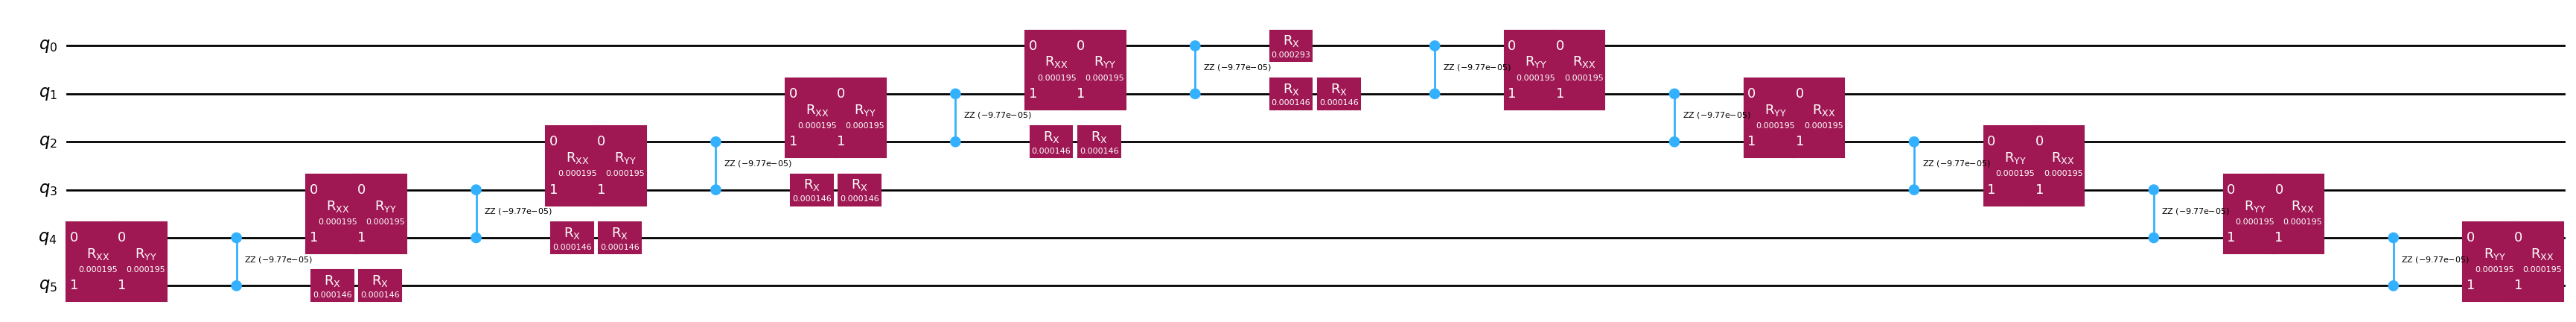

In [5]:
# Construct a single Trotter step of the target circuit
from qiskit.synthesis import SuzukiTrotter
from qiskit_addon_utils.problem_generators import generate_time_evolution_circuit

aqc_evolution_time = t
aqc_target_log2_num_trotter_steps = 10

aqc_target_step_circuit_h = generate_time_evolution_circuit(
    hamiltonian_heisenberg,
    synthesis=SuzukiTrotter(reps=1),
    time=aqc_evolution_time / 2**aqc_target_log2_num_trotter_steps,
)

print(
    f"This single Trotter step circuit will be repeated {2**aqc_target_log2_num_trotter_steps} times:"
)
aqc_target_step_circuit_h.draw("mpl", fold=-1)

In [6]:
# construct a good cirucit

ansatz_num_trotter_steps = 5

aqc_good_circuit_h = generate_time_evolution_circuit(
    hamiltonian_heisenberg,
    synthesis=SuzukiTrotter(reps=ansatz_num_trotter_steps),
    time=aqc_evolution_time,
)

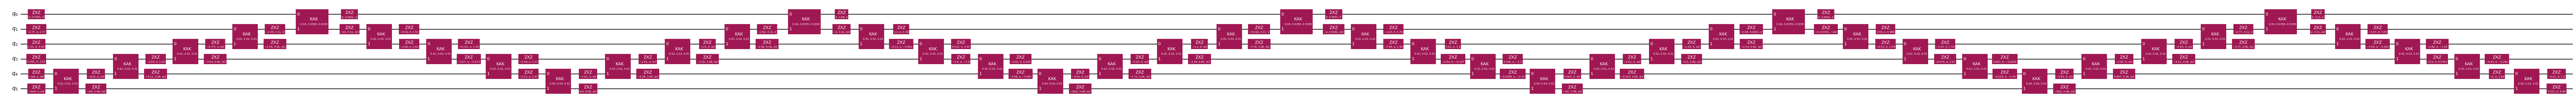

In [7]:
# generate ansatz from a good circuit
from qiskit_addon_aqc_tensor import generate_ansatz_from_circuit

aqc_ansatz_h, aqc_initial_parameters_h = generate_ansatz_from_circuit(
    aqc_good_circuit_h, parameter_name="x"
)
aqc_ansatz_h.assign_parameters(aqc_initial_parameters_h).draw("mpl", fold=-1)

In [8]:
print(aqc_ansatz_h.depth())

83


In [9]:
# set up quimb
from functools import partial
import quimb.tensor
from qiskit_addon_aqc_tensor.simulation.quimb import QuimbSimulator

simulator_settings = QuimbSimulator(
    partial(quimb.tensor.Circuit, gate_contract="split-gate"),
    autodiff_backend="jax",
)

/Users/aag/Documents/ropt-aqc/ropt-aqc_venv/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:54: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/Users/aag/Documents/ropt-aqc/ropt-aqc_venv/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:73: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(


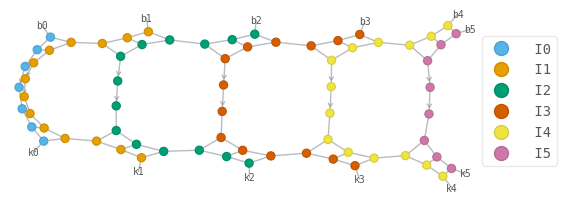

In [10]:
# construct target MPO - tensor network of single trotter step of target circuit
from qiskit_addon_aqc_tensor.simulation import tensornetwork_from_circuit

aqc_target_mpo_h = tensornetwork_from_circuit(aqc_target_step_circuit_h, simulator_settings).get_uni()
aqc_target_mpo_h.draw(aqc_target_mpo_h.site_tags, show_tags=False)

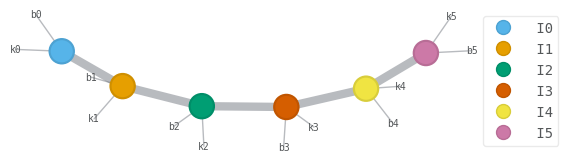

In [11]:
# contract and fuse multibonds to form MPO

for site in aqc_target_mpo_h.site_tags:
    aqc_target_mpo_h.contract(site, inplace=True)
aqc_target_mpo_h.fuse_multibonds_()

aqc_target_mpo_h.draw(aqc_target_mpo_h.site_tags, show_tags=False)

In [12]:
# cast to MPO object and compress
cutoff = 1e-8

aqc_target_mpo_h.view_as_(
    quimb.tensor.MatrixProductOperator,
    cyclic=False,
    L=coupling_map.num_nodes(),
)
aqc_target_mpo_h.compress(cutoff=cutoff)
aqc_target_mpo_h.show()

│3│3│3│3│3│
●─<─<─<─<─<
│ │ │ │ │ │


In [13]:
# repeatedly sqaure and compress MPO to represent an operator with many Trotter steps
for _ in range(aqc_target_log2_num_trotter_steps):
    aqc_target_mpo_h = aqc_target_mpo_h.apply(aqc_target_mpo_h)
    aqc_target_mpo_h.compress(cutoff=cutoff)
    aqc_target_mpo_h.show()
aqc_target_mpo_h

│3│3│3│3│3│
●─<─<─<─<─<
│ │ │ │ │ │
│3│3│3│3│3│
●─<─<─<─<─<
│ │ │ │ │ │
│3│3│3│3│3│
●─<─<─<─<─<
│ │ │ │ │ │
│3│3│3│3│3│
●─<─<─<─<─<
│ │ │ │ │ │
│3│3│3│3│3│
●─<─<─<─<─<
│ │ │ │ │ │
│3│3│3│3│3│
●─<─<─<─<─<
│ │ │ │ │ │
│4│4│4│4│4│
●─<─<─<─<─<
│ │ │ │ │ │
│4│4│4│4│4│
●─<─<─<─<─<
│ │ │ │ │ │
│4│6│6│6│4│
●─<─<─<─<─<
│ │ │ │ │ │
│4│11│11│11│4│
●─<──<──<──<─<
│ │  │  │  │ │


MatrixProductOperator(tensors=6, indices=17, L=6, max_bond=11)

In [14]:
from scipy.optimize import OptimizeResult, minimize

from qiskit_addon_aqc_tensor.objective import MaximizeUnitaryFidelity

aqc_ansatz_h, aqc_initial_parameters_h = generate_ansatz_from_circuit(decomposed_circuit_h)

objective = MaximizeUnitaryFidelity(aqc_target_mpo_h, aqc_ansatz_h, simulator_settings)

stopping_point = 1e-4


def my_loss_function(*args):
    val, grad = objective.loss_function(*args)
    print(f"Evaluating loss function: {1 - val:.8}")
    return val, grad


def callback(intermediate_result: OptimizeResult):
    print(f"Intermediate result: Fidelity {1 - intermediate_result.fun:.8}")
    if intermediate_result.fun < stopping_point:
        # Good enough for now
        raise StopIteration


result_h = minimize(
    my_loss_function,
    aqc_initial_parameters_h,
    method="L-BFGS-B",
    jac=True,
    options={"maxiter": 100},
    callback=callback,
)
if result_h.status not in (
    0,
    1,
    99,
):  # 0 => success; 1 => max iterations reached; 99 => early termination via StopIteration
    raise RuntimeError(f"Optimization failed: {result_h.message} (status={result_h.status})")

print(f"Done after {result_h.nit} iterations.")
aqc_final_parameters_h = result_h.x

Evaluating loss function: 2.9861927e-05
Evaluating loss function: 0.025765777
Intermediate result: Fidelity 0.025765777
Evaluating loss function: 0.016273201
Evaluating loss function: 0.040143788
Evaluating loss function: 0.0087504387
Evaluating loss function: 0.041366816
Evaluating loss function: 0.042580962
Intermediate result: Fidelity 0.042580962
Evaluating loss function: 0.011117995
Evaluating loss function: 0.026954949
Evaluating loss function: 0.04343015
Intermediate result: Fidelity 0.04343015
Evaluating loss function: 0.11499739
Evaluating loss function: 0.24284267
Intermediate result: Fidelity 0.24284267
Evaluating loss function: 0.15928817
Evaluating loss function: 0.06445843
Evaluating loss function: 0.1633423
Evaluating loss function: 0.25938904
Intermediate result: Fidelity 0.25938904
Evaluating loss function: 0.27928591
Evaluating loss function: 0.36962736
Intermediate result: Fidelity 0.36962736
Evaluating loss function: 0.49155784
Intermediate result: Fidelity 0.491557

=== Complete Optimised Circuit ===


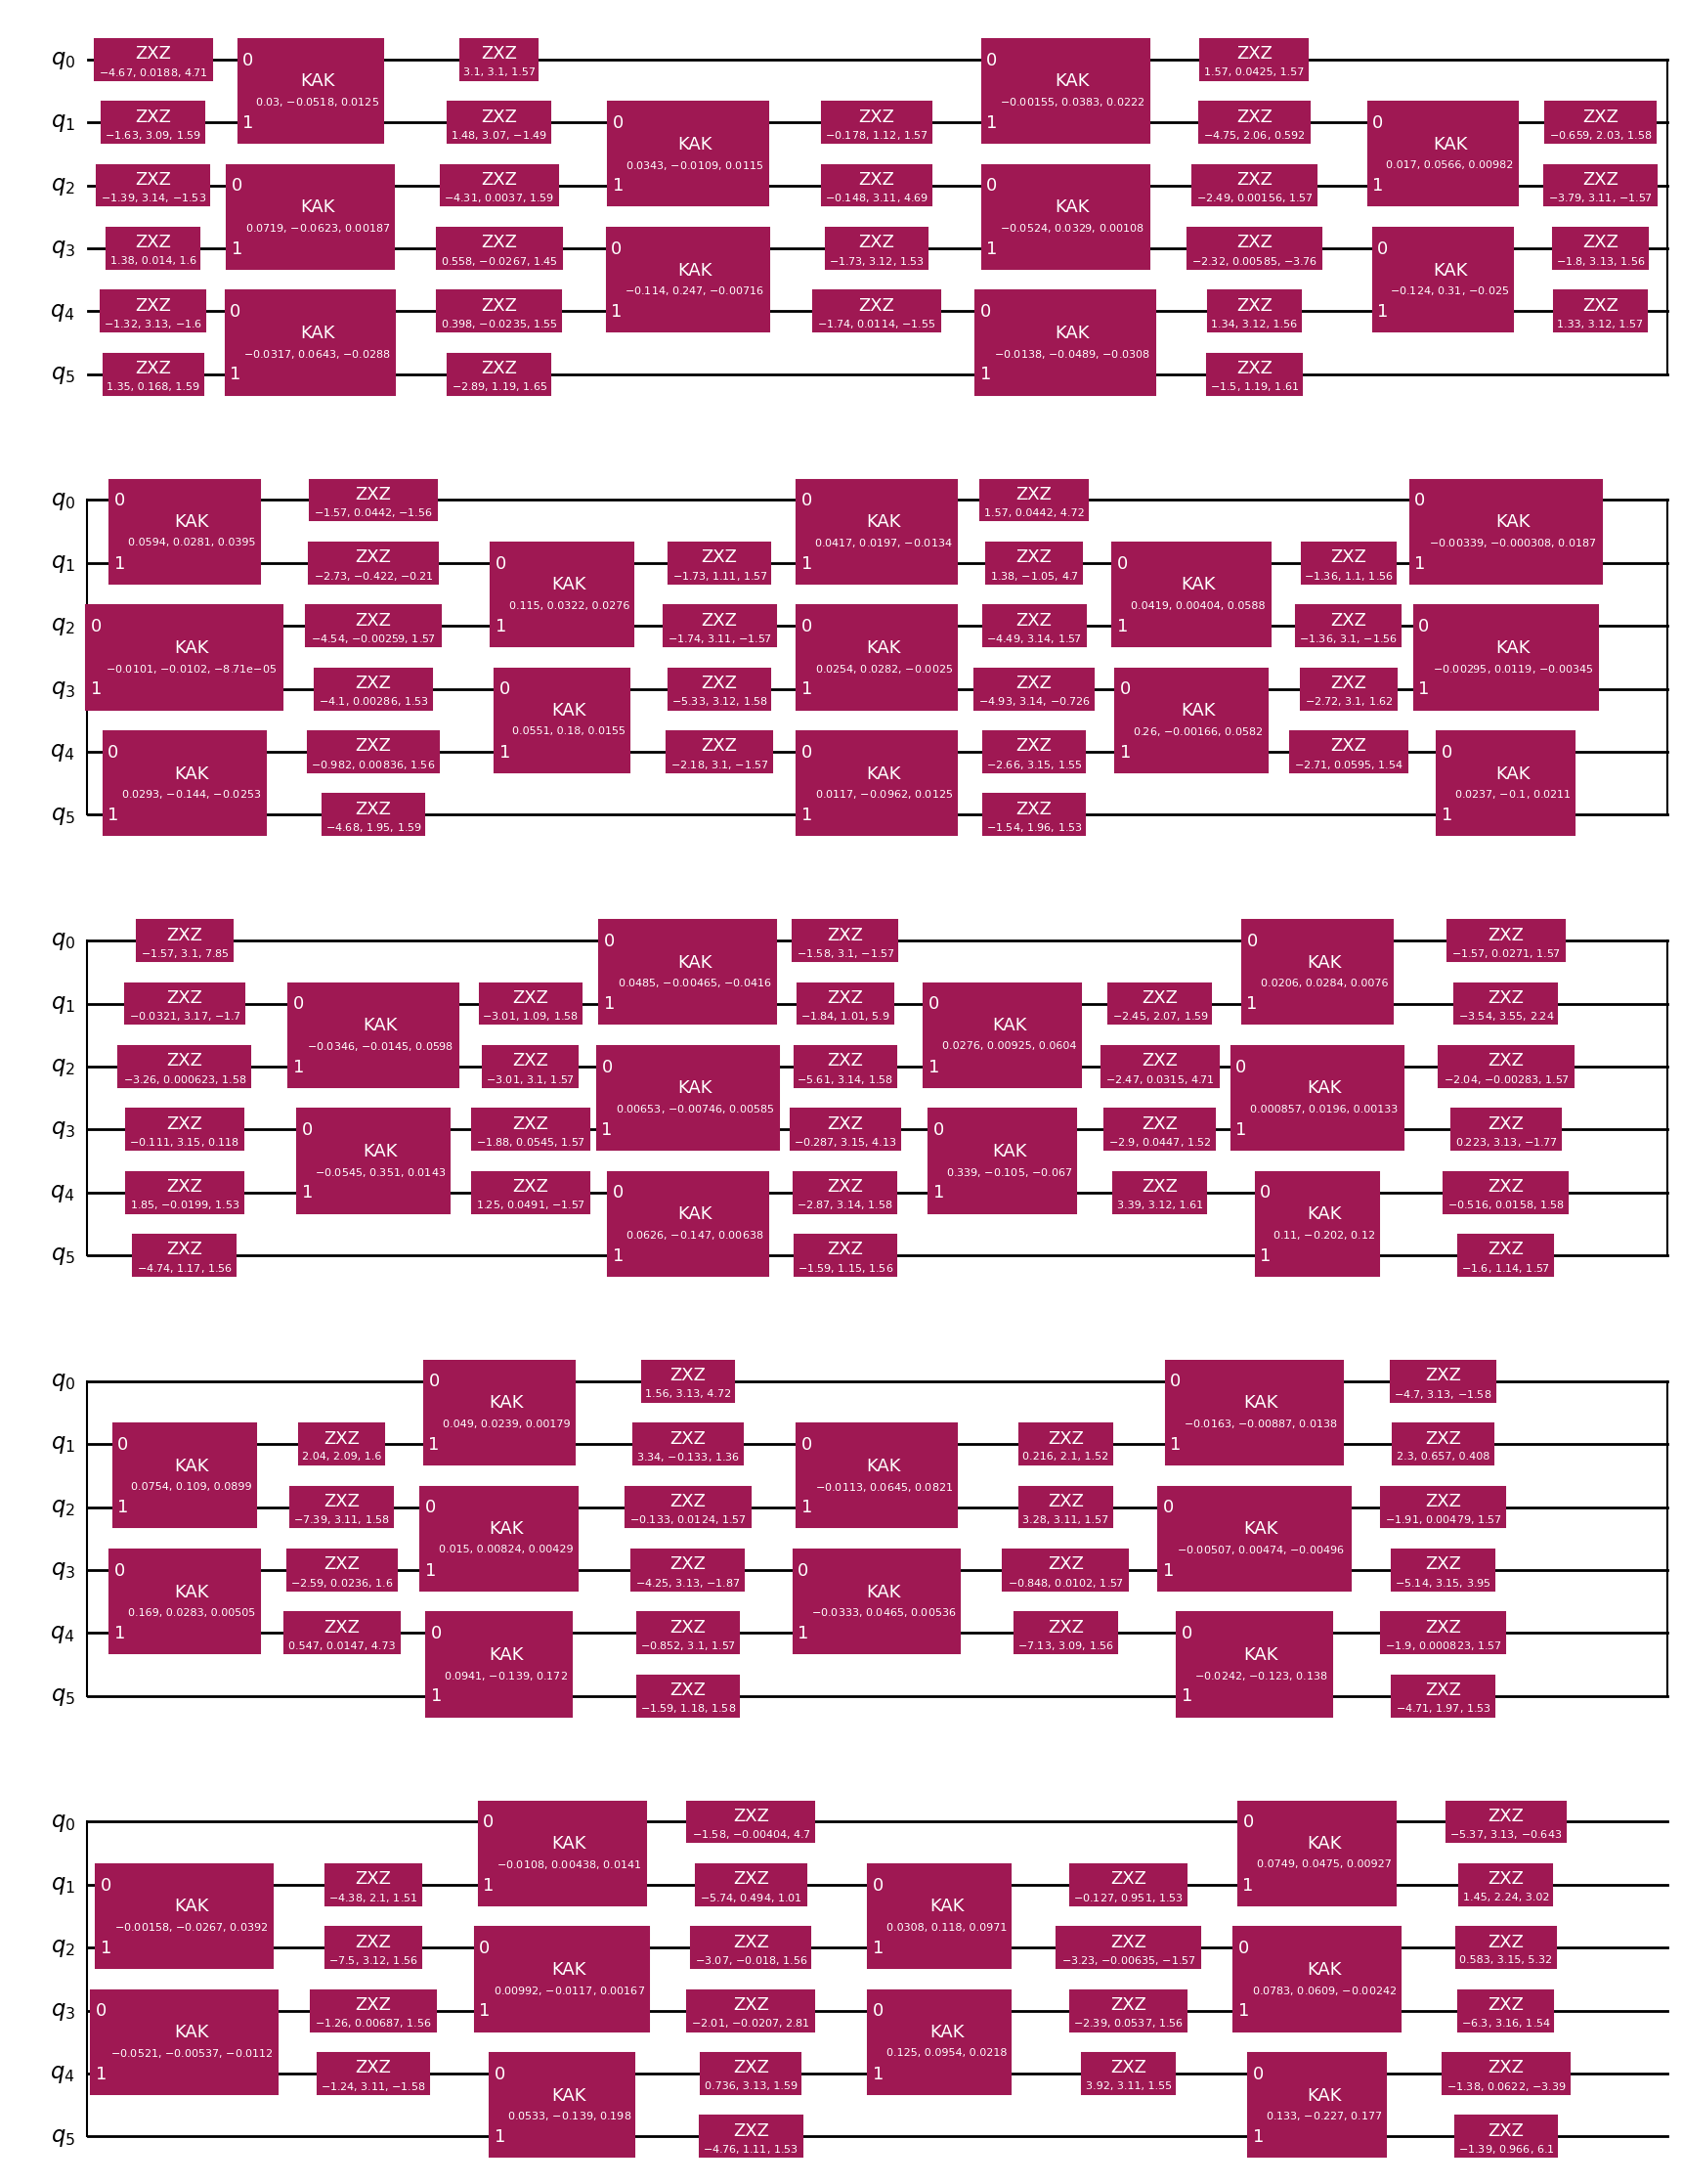

In [15]:
# from the optimised circuit 
aqc_optimised_block_h = aqc_ansatz_h.assign_parameters(aqc_final_parameters_h)
print("=== Complete Optimised Circuit ===")
aqc_optimised_block_h.draw("mpl")

In [16]:
original_depth_h = aqc_optimised_block_h.depth()
print(original_depth_h)

43


In [17]:
# calculate Frobenius inner product 
import numpy as np
from qiskit.quantum_info import Operator

if coupling_map.num_nodes() <= 8:
    target_operator_h = Operator(aqc_target_step_circuit_h).power(2**aqc_target_log2_num_trotter_steps)
    
    initial_fidelity_h = abs(
        np.trace(Operator(aqc_good_circuit_h).conjugate().to_matrix() @ target_operator_h.to_matrix())
        / 2.0 ** coupling_map.num_nodes()
    )
    print(f"Initial Frobenius inner product: {initial_fidelity_h:.8}")

    final_fidelity_h = abs(
        np.trace(
            Operator(aqc_optimised_block_h).conjugate().to_matrix() @ target_operator_h.to_matrix()
        )
        / 2.0 ** coupling_map.num_nodes()
    )
    print(f"Final Frobenius inner product: {final_fidelity_h:.8}")

Initial Frobenius inner product: 0.9999993
Final Frobenius inner product: 0.97642949


The final circuit implements evolution of the Hamiltonian for time = 0.8.


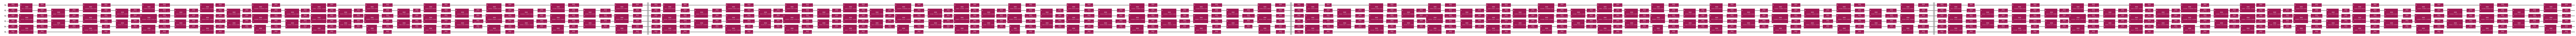

In [18]:
# Form final circuit by repeating the block
num_repeats = 4

print(
    f"The final circuit implements evolution of the Hamiltonian for time = {num_repeats * aqc_evolution_time}."
)  # FIXME: can i say anything about the fidelity??  ignoring cutoff/roundoff error of course
final_circuit_h = aqc_optimised_block_h.repeat(num_repeats)

aqc_optimised_block_h.repeat(num_repeats, insert_barriers=True).decompose().draw("mpl", fold=-1)

In [19]:
# Now slice and compress
from ropt_aqc.comparison_methods import compress_AQC_unitary

N_vals = range(1,original_depth_h)

df_h, aqc_ansatz_h, aqc_initial_parameters_h, aqc_final_parameters_h = compress_AQC_unitary(aqc_ansatz_h, aqc_initial_parameters_h, aqc_good_circuit_h, aqc_target_mpo_h, N_vals, simulator_settings, n_repetitions)


=== Optimizing with N = 1 layers ===
Evaluating loss function: 4.1404461e-05
Evaluating loss function: 0.0042896627
Evaluating loss function: 0.0048201994
Evaluating loss function: 0.020611453
Evaluating loss function: 0.0015576591
Evaluating loss function: 0.0014488043
Evaluating loss function: 0.012792418
Evaluating loss function: 0.021864625
Intermediate result: Fidelity 0.021864625
Evaluating loss function: 0.0046040654
Evaluating loss function: 0.011096328
Evaluating loss function: 0.022315735
Intermediate result: Fidelity 0.022315735
Evaluating loss function: 0.048457197
Intermediate result: Fidelity 0.048457197
Evaluating loss function: 0.087763413
Evaluating loss function: 0.36481065
Evaluating loss function: 0.0023843229
Evaluating loss function: 0.37312839
Intermediate result: Fidelity 0.37312839
Evaluating loss function: 0.0025632232
Evaluating loss function: 0.0079466581
Evaluating loss function: 0.38317262
Intermediate result: Fidelity 0.38317262
Evaluating loss function:

In [20]:
import pandas as pd
file_path_heisenberg = f'/Users/aag/Documents/ropt-aqc/method_comparison/results/AQC_unitary_trotter_warmstart_Heisenberg_results_0.2_0.2.csv'

df_h.to_csv(file_path_heisenberg, index=False, header=True)
# df_h.to_csv(file_path_heisenberg, index=False, mode="a", header=False)

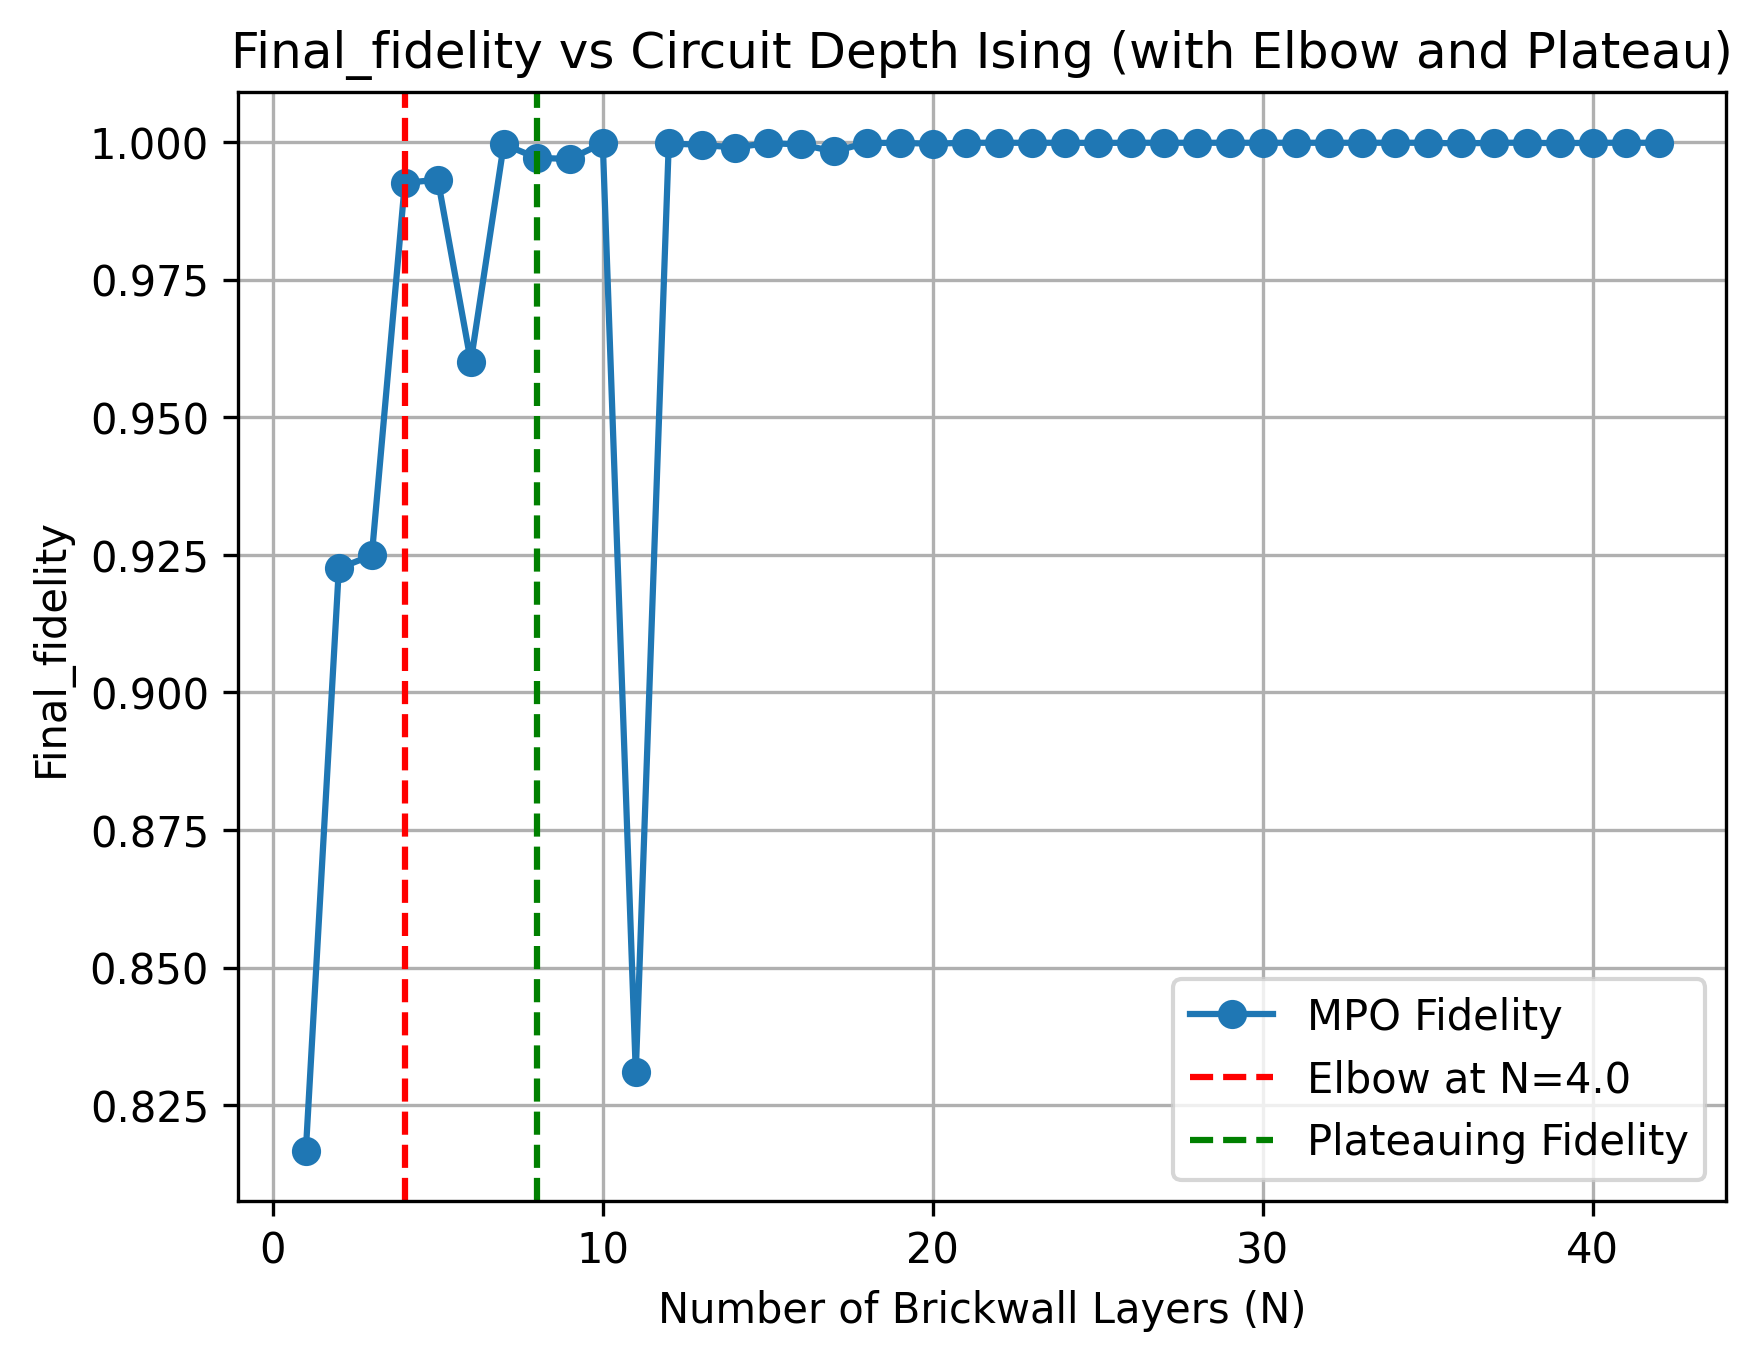


🔍 Suggested optimal compression depth: N = 8.0


In [21]:
from ropt_aqc.brickwall_opt import plot_fidelity
df_h = pd.read_csv(file_path_heisenberg)
method = 'trotter-aqc'

elbow_N_h, plateau_N_h = plot_fidelity(df_h, 'Final_fidelity', t, 1e-2, method, system, save_path=True)

In [41]:
# Compress circuit
# N_vals = [int(plateau_N_h)]
from ropt_aqc.comparison_methods import compress_AQC_unitary

N_vals =[21]
df_compressed_h, aqc_ansatz_compressed_h, aqc_initial_parameters_compressed_h, aqc_final_parameters_compressed_h = compress_AQC_unitary(aqc_ansatz_h, aqc_initial_parameters_h, aqc_good_circuit_h, aqc_target_mpo_h, N_vals, simulator_settings, n_repetitions)


=== Optimizing with N = 21 layers ===
Evaluating loss function: 7.6578166e-05
Evaluating loss function: 0.0052529306
Intermediate result: Fidelity 0.0052529306
Evaluating loss function: 0.0049848565
Evaluating loss function: 0.0072521693
Intermediate result: Fidelity 0.0072521693
Evaluating loss function: 0.026516684
Evaluating loss function: 0.057242108
Evaluating loss function: 0.070274894
Evaluating loss function: 0.077056961
Intermediate result: Fidelity 0.077056961
Evaluating loss function: 0.0088709839
Evaluating loss function: 0.011207591
Evaluating loss function: 0.082345681
Intermediate result: Fidelity 0.082345681
Evaluating loss function: 0.18154143
Evaluating loss function: 0.045910675
Evaluating loss function: 0.25960979
Intermediate result: Fidelity 0.25960979
Evaluating loss function: 0.01597551
Evaluating loss function: 0.27469893
Intermediate result: Fidelity 0.27469893
Evaluating loss function: 0.46945316
Intermediate result: Fidelity 0.46945316
Evaluating loss funct

In [42]:
print("=== Compressed Optimised Circuit ===")
aqc_optimised_compressed_h = aqc_ansatz_compressed_h.assign_parameters(aqc_final_parameters_compressed_h)
aqc_optimised_compressed_h.draw("mpl")
aqc_optimised_compressed_h.draw("mpl").savefig('optimised_circuit_AQC-u_Heisenberg.pdf')


=== Compressed Optimised Circuit ===


In [43]:
print("\n=== Compressed Optimised Parameters ===")
for param, value in zip(aqc_ansatz_compressed.parameters, aqc_final_parameters_compressed):
    print(f"{param}: {value:.6f}")


=== Compressed Optimised Parameters ===
x[0]: -0.993831
x[1]: 1.704573
x[2]: 6.901356
x[3]: -1.591118
x[4]: 1.564426
x[5]: 4.476437
x[6]: -1.559196
x[7]: 1.560501
x[8]: 1.287993
x[9]: -1.797327
x[10]: 1.407949
x[11]: 4.341333
x[12]: -2.369698
x[13]: 1.208798
x[14]: 1.320851
x[15]: -1.760783
x[16]: 1.204503
x[17]: 4.230942
x[18]: 0.604689
x[19]: 0.011579
x[20]: -0.043093
x[21]: -3.110047
x[22]: 1.930415
x[23]: 3.333391
x[24]: -0.759691
x[25]: 1.442009
x[26]: 3.415362
x[27]: 0.569287
x[28]: -0.010928
x[29]: 0.009078
x[30]: 0.006790
x[31]: 2.517496
x[32]: 0.137384
x[33]: -2.503677
x[34]: 2.156799
x[35]: 2.735852
x[36]: 0.463527
x[37]: -0.010863
x[38]: -0.000870
x[39]: -3.187663
x[40]: 2.359032
x[41]: 3.235836
x[42]: -2.880347
x[43]: 0.476879
x[44]: 0.648416
x[45]: 0.425240
x[46]: -0.000799
x[47]: 0.001250
x[48]: -3.164749
x[49]: 0.542738
x[50]: 2.503126
x[51]: -2.437825
x[52]: 1.670818
x[53]: 0.163219
x[54]: 0.822849
x[55]: 0.183498
x[56]: -0.004233
x[57]: -1.020835
x[58]: 1.213286
x[59]

In [44]:
print(f"Number of parameters in ansatz: {len(aqc_ansatz_compressed_h.parameters)}")
print(f"Physical depth of compressed circuit: {aqc_optimised_compressed_h.depth()}")
print(f"Compression ratio: {original_depth_h / aqc_optimised_compressed_h.depth()}")


Number of parameters in ansatz: 108
Physical depth of compressed circuit: 21
Compression ratio: 3.9523809523809526
